# GWRATES complete exmaples

## Short BBH example with three detectors
* This part of the notebook is a short example to simulate a binary black hole mergers and calculate its rate ($yr^{-1}$). 

In [1]:
# call the GWRATES class
from ler.rates import GWRATES

In [2]:
# class initialization
# >>> ler = GWRATES() # if you want the models and its parameters to print
# set 'npool' according to your machine's available CPU cores. Default is 4.
# to check no. of cores, 
# >>> import multiprocessing as mp
# >>> print(mp.cpu_count())
ler = GWRATES(verbose=False)

In [3]:
# simulation of the GW CBC population
# this will generate a json file with the simulated population parameters
# # by default 100,000 events will be sampled with batches of 25,000. 
# results will be saved in the same directory as json file.
# resume=True will resume the simulation from the last saved batch.
param = ler.gw_cbc_statistics(resume=True)

simulated gw params will be stored in ./gw_param.json
chosen batch size = 25000 with total size = 100000
There will be 4 batche(s)
resuming from ./gw_param.json


In [4]:
# generate detectable events
# note: here no input param is provided, so it will track the json file generated above
# final rate is the rate of detectable events
rate, param_detectable = ler.gw_rate()

getting gw_params from json file ./gw_param.json...
total gw rate (yr^-1) (with step function): 437.9018524996516
storing detectable gw params in ./gw_param_detectable.json


In [5]:
# available parameters
# Note: This is for spin-less systems.
param_detectable.keys()

dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'H1', 'V1', 'snr_net'])

In [7]:
# all gwrates initialization parameters, simulated parameters's json file names and rate results are strored as json file in the same directory
from ler.utils import load_json
ler_params = load_json('./gwrates_params.json')
print(ler_params)

{'npool': '4', 'z_min': '0.0', 'z_max': '10.0', 'size': '100000', 'batch_size': '25000', 'cosmology': 'LambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Ode0=0.7, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)', 'snr_finder': '<bound method GWSNR.snr of <gwsnr.gwsnr.GWSNR object at 0x296eec670>>', 'json_file_names': "{'gwrates_param': './gwrates_params.json', 'gw_param': './gw_param.json', 'gw_param_detectable': './gw_param_detectable.json'}", 'directory': './interpolator_pickle', 'gw_param_sampler_dict': {'z_min': '0.0', 'z_max': '10.0', 'event_type': 'BBH', 'source_priors': "{'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018', 'source_frame_masses': 'binary_masses_BBH_popI_II_powerlaw_gaussian', 'zs': 'sample_source_redshift', 'geocent_time': 'sampler_uniform', 'ra': 'sampler_uniform', 'dec': 'sampler_cosine', 'phase': 'sampler_uniform', 'psi': 'sampler_uniform', 'theta_jn': 'sampler_sine'}", 'source_priors_params': "{'merger_rate_density': {'R0': 2.5000000000000002e-08, 'b2': 1

getting gw_params from json file ./gw_param_detectable.json...
getting gw_params from json file ./gw_param.json...


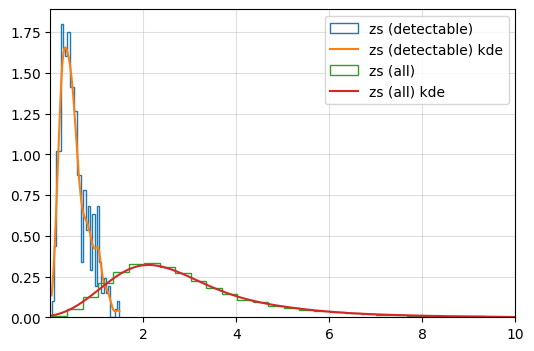

In [6]:
import matplotlib.pyplot as plt
from ler.utils import plots as lerplt

# plotting the distribution of event parameters
# param_dict can be either a dictionary or a json file name that contains the parameters
plt.figure(figsize=(6, 4))
lerplt.param_plot(
    param_name='zs',
    param_dict='./gw_param_detectable.json',
    plot_label='zs (detectable)',
)
lerplt.param_plot(
    param_name='zs',
    param_dict='./gw_param.json',
    plot_label='zs (all)',
)
plt.xlim(0.001,10)
plt.grid(alpha=0.4)
plt.show()

## Custom functions
* `ler` allows internal model functions to be change with custom functions.
* It also allows to change the default parameters of the existing model functions.

In [1]:
# First let's look at what are the input parameters available for ler.GWRATES
# The input paramters can divided into three categories
# 1. ler.GWRATES set up params
# 2. ler.CBCSourceParameterDistribution set up params (as kwargs)
# 3. gwsnr.GWSNR set up params (as kwargs)
import matplotlib.pyplot as plt
from ler.rates import GWRATES
ler = GWRATES(npool=4, verbose=True)

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_1.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
merger_rate_density_bbh_popI_II_oguri2018 interpolator will be loaded from ./interpolator_pickle/merger_rate_density_bbh_popI_II_oguri2018/merger_rate_density_bbh_popI_II_oguri2018_5.pickle
npool:  4
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
min(ratio):  0.1
max(ratio):  1.0
mtot resolution:  100
ratio resolution:  50
interpolator directory:  ./interpolator_pickle
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/halfSNR_dict_4.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/halfSN

As an example, I will change,
  * merger_rate_density_params's default value of **local merger rate density** ($R_0$) to 2.3e-9 $Mpc^{-3} yr^{-1}$. But, I am still using the default merger_rate_density function, which is 'merger_rate_density_bbh_popI_II_oguri2018'.
  * **source_frame_masses** to a custom function. This is similar to the internal default function, i.e. PowerLaw+Peak model. I am using `gwcosmo`'s powerlaw_gaussian prior for this example.
  * `gwsnr` parameters: By default, it uses 'IMRPhenomD' **waveform model** with no spin. It uses interpolation method to find the 'snr' and it is super fast. But for the example below, I am using 'IMRPhenomXPHM` with precessing spins. This is without interpolation but through inner product method. It will be slower.

In [2]:
from gwcosmo import priors as p

# define your custom function of mass_1_source and mass_2_source calculation
# all ler internal functions are defined in a similar way
def powerlaw_peak(size, mminbh=4.98, mmaxbh=86.22, alpha=2.63, mu_g=33.07, sigma_g=5.69, lambda_peak=0.10, delta_m=4.82, beta=1.26, param=None):
    """
    Function to sample mass1 and mass2 from a powerlaw with a gaussian peak

    Parameters
    ----------
    size : `int`
        Number of samples to draw
    mminbh : `float`
        Minimum mass of the black hole (Msun)
        default: 4.98
    mmaxbh : `float`
        Maximum mass of the black hole (Msun)
        default: 86.22
    alpha : `float`
        Spectral index for the powerlaw of the primary mass distribution
        default: 2.63
    mu_g : `float`
        Mean of the Gaussian component in the primary mass distribution
        default: 33.07
    sigma_g : `float`
        Width of the Gaussian component in the primary mass distribution
        default: 5.69
    lambda_peak : `float`
        Fraction of the model in the Gaussian component
        default: 0.10
    delta_m : `float`
        Range of mass tapering on the lower end of the mass distribution
        default: 4.82
    beta : `float`
        Spectral index for the powerlaw of the mass ratio distribution
        default: 1.26
    param : `dict`
        Dictionary of parameters for the model. This will override the above.
    """

    if param:
        mminbh = param['mminbh']
        mmaxbh = param['mmaxbh']
        alpha = param['alpha']
        mu_g = param['mu_g']
        sigma_g = param['sigma_g']
        lambda_peak = param['lambda_peak']
        delta_m = param['delta_m']
        beta = param['beta']

    model = p.BBH_powerlaw_gaussian(
        mminbh=mminbh,
        mmaxbh=mmaxbh,
        alpha=alpha,
        mu_g=mu_g,
        sigma_g=sigma_g,
        lambda_peak=lambda_peak,
        delta_m=delta_m,
        beta=beta,
    )
    # sample mass1 and mass2
    mass_1_source, mass_2_source = model.sample(Nsample=size)

    return (mass_1_source, mass_2_source)


In [4]:
# Initialize the class with the custom function
# changing gwrates input params
ler = GWRATES(npool=4, verbose=False,
    source_priors=dict(
        merger_rate_density='merger_rate_density_bbh_popI_II_oguri2018',
        source_frame_masses=powerlaw_peak,
    ),
   source_priors_params=dict(
        merger_rate_density=dict(
            R0=2.9e-08,
            b2=1.6,
            b3=2.0,
            b4=30
        ),
        source_frame_masses=dict(
            mminbh=4.98,
            mmaxbh=86.22,
            alpha=2.63,
            mu_g=33.07,
            sigma_g=5.69,
            lambda_peak=0.10,
            delta_m=4.82,
            beta=1.26
        ),
   ),
   waveform_approximant = 'IMRPhenomXPHM',
   snr_type='inner_product',
   spin_zero=False,
   spin_precession=True,
)

In [7]:
# simulation of the GW CBC population
# you can set the batch size at the gwarates initialization
# or you can set it using the `batch_size` instance variable
# if the sample size is large, it is recommended to set the batch size to a large number, but it will consume more RAM memory or simply your machine's individual core won't be able to handle it.
ler.batch_size = 50000
ler.gw_cbc_statistics(size=100000, resume=True, output_jsonfile = './new_gw_params.json');


simulated gw params will be stored in ./new_gw_params.json
chosen batch size = 50000 with total size = 100000
There will be 2 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


100%|████████████████████████████████████████████████████████| 40639/40639 [00:52<00:00, 769.22it/s]


Batch no. 2
sampling gw source params...
calculating snrs...
solving SNR with inner product


100%|████████████████████████████████████████████████████████| 40638/40638 [00:53<00:00, 765.68it/s]


In [8]:
# Note: you can also also called the generate parameters using an instance attribute. This instance attribute gets the dict from the json file generated above.
# Note: This is for spin-precessing systems, and it will contain extra (spin-related) parameters.
param = ler.gw_param
print(param.keys())

dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'H1', 'V1', 'snr_net'])


In [6]:
# generate detectable events
# and get the rate of detectable events
# You have two choice to input the generated parameters, either as json file name or as a dict
rate, param_detectable = ler.gw_rate(
    gw_param='./new_gw_params.json',
    snr_threshold=10.0,
    output_jsonfile='./new_gw_params_detectable.json',
)

getting gw_params from json file ./new_gw_params.json...
total gw rate (yr^-1) (with step function): 854.0638967191786
storing detectable gw params in ./new_gw_params_detectable.json


In [7]:
# to check all the stored json file names
ler.json_file_names

{'gwrates_param': './gwrates_params.json',
 'gw_param': './new_gw_params.json',
 'gw_param_detectable': './new_gw_params_detectable.json'}

In [8]:
# again you can call the generated detectable events' parameters using an instance attribute
# Note: The data is not stored in this instance attribute, it is stored in the json file. This scheme is used to save RAM memory.
param_detectable = ler.gw_param_detectable
print(param_detectable.keys())

dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'H1', 'V1', 'snr_net'])


### How to look for available model functions?

In [20]:
# All available names are stored as a dict in ler instance
# the keys of this dict shows the parameter type
# the values are also dict, where the keys are the model function names and the values are their input parameters
ler.available_gw_prior_list_and_its_params['source_frame_masses']

{'binary_masses_BBH_popI_II_powerlaw_gaussian': {'mminbh': 4.98,
  'mmaxbh': 112.5,
  'alpha': 3.78,
  'mu_g': 32.27,
  'sigma_g': 3.88,
  'lambda_peak': 0.03,
  'delta_m': 4.8,
  'beta': 0.81},
 'binary_masses_BBH_popIII_lognormal': {'Mc': 30.0, 'sigma': 0.3, 'beta': 1.1},
 'binary_masses_BBH_primordial_lognormal': {'Mc': 30.0,
  'sigma': 0.3,
  'beta': 1.1},
 'binary_masses_BNS_gwcosmo': {'mminns': 1.0, 'mmaxns': 3.0, 'alphans': 0.0},
 'binary_masses_BNS_bimodal': {'w': 0.643,
  'muL': 1.352,
  'sigmaL': 0.08,
  'muR': 1.88,
  'sigmaR': 0.3,
  'mmin': 1.0,
  'mmax': 2.3}}

In [8]:
# for looking at the choosen models and its input parameters
print(ler.gw_param_samplers)
print(ler.gw_param_samplers_params)

{'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018', 'source_frame_masses': 'binary_masses_BBH_popI_II_powerlaw_gaussian', 'zs': 'sample_source_redshift', 'geocent_time': 'sampler_uniform', 'ra': 'sampler_uniform', 'dec': 'sampler_cosine', 'phase': 'sampler_uniform', 'psi': 'sampler_uniform', 'theta_jn': 'sampler_sine'}
{'merger_rate_density': {'R0': 2.5000000000000002e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30}, 'source_frame_masses': {'mminbh': 4.98, 'mmaxbh': 112.5, 'alpha': 3.78, 'mu_g': 32.27, 'sigma_g': 3.88, 'lambda_peak': 0.03, 'delta_m': 4.8, 'beta': 0.81}, 'zs': None, 'geocent_time': {'min_': 1238166018, 'max_': 1269702018}, 'ra': {'min_': 0.0, 'max_': 6.283185307179586}, 'dec': None, 'phase': {'min_': 0.0, 'max_': 6.283185307179586}, 'psi': {'min_': 0.0, 'max_': 3.141592653589793}, 'theta_jn': None}


## Using internal model functions

In [9]:
# calling the default mass distribution model
mass_1_source, mass_2_source = ler.binary_masses_BBH_popI_II_powerlaw_gaussian(size=10000)
default_model = dict(mass_1_source=mass_1_source)

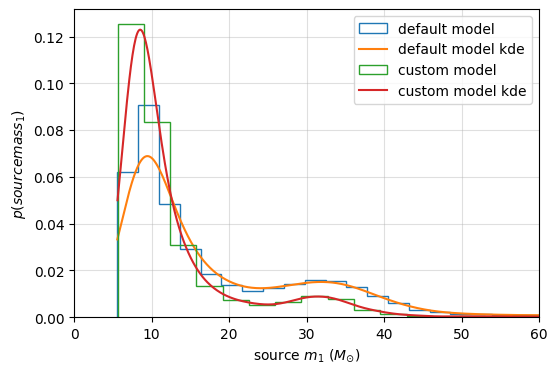

In [12]:
import matplotlib.pyplot as plt
from ler.utils import plots as lerplt

# let's do a comparision plot between you custom model and the default model
plt.figure(figsize=(6, 4))
lerplt.param_plot(
    param_name="mass_1_source", 
    param_dict=param, # or the json file name
    plot_label='default model',
);
lerplt.param_plot(
    param_name="mass_1_source", 
    param_dict=default_model,
    plot_label='custom model',
);
plt.xlabel(r'source $m_1$ ($M_{\odot}$)')
plt.ylabel(r'$p(source mass_1)$')
plt.xlim(0,60)
plt.grid(alpha=0.4)
plt.show()


## Selecting particular number of detectable events

In [9]:
from ler.rates import GWRATES

# class initialization
ler = GWRATES(verbose=False)

In [10]:
n_size_param = ler.selecting_n_gw_detectable_events(
    size=500, 
    snr_threshold=10.0,
    batch_size=25000,
    output_jsonfile='./gw_params_n_detectable.json'
    )

collected number of events =  0
collected number of events =  108
collected number of events =  215
collected number of events =  336
collected number of events =  445
collected number of events =  522
trmming final result to size=500


In [11]:
print(n_size_param.keys())
print(f"size of each parameters={len(n_size_param['zs'])}")

dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'H1', 'V1', 'snr_net'])
size of each parameters=500
